# AI4I 2020 Predictive Maintenance Dataset Data Set

><font color='blue'  size="4"> KAUSHIK SIRVOLE <font> <br>
> <font color='blue'  size="3"> 5/7/2022
    

## Information Provided

### Data Set Information:
Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge.

###  Attribute Information:

The dataset consists of 10,000 data points stored as rows with 14 features in columns
- **UID**: unique identifier ranging from 1 to 10000
- **product ID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- **air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- **process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- **rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise
- **torque [Nm]**: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
- **tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- **'machine failure'** label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
- **tool wear failure (TWF)**: the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- **heat dissipation failure (HDF)**: heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm. This is the case for 115 data points.
- **power failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- **overstrain failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- **random failures (RNF)**: each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

In [2]:
## ai4i2020.csv

## Importing Dependancies and Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import re

C:\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
sns.set()
plt.rcParams['figure.figsize'] = [10,5]
pd.options.display.max_colwidth = 50
pd.options.display.max_columns = 500

In [6]:
#import data csv into pandas dataframe
data = pd.read_csv("ai4i2020.csv")

In [7]:
# check the size of the dataset
data.shape

(10000, 14)

In [8]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [9]:
# understand the structure of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [10]:
# check for null entries in all columns
data.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

- if NULL entries are found.<br> 
    - Delete the observation or 
    - Perform imputation

In [11]:
data.describe(include=[np.number])

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [12]:
data["Machine failure"].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

## Problem Statement

### Preliminary Thoughts

- The data provides the insight into the different combination of 'features' that either resulted in machine failures or not and what was the failure mode. <br>
- Note that this is not the data where one can attempt to predict a future failure and take steps to mitigate such scenario. If there is an availability of time history of the **feature parameters** that led to eventual **machine failure** and similar data for **normal operation**,  the data lends itself to answering such forecasting question. <br> 
- In the current case, we can build a predictor model that can help classify  ***If a combination of parameters will lead to machine failure classification***.

### Classification Problem

With the data on machine failure, and the corresponding failure modes we can construct two different classification problems.

#### <font color='blue'> 1. Predict a potential **Machine failure** as the target variable, with base parameters as features </font>
> **Binary Classification Problem with Multivariate features**

                           OR

#### <font color='blue'> 2. Classify a potential **failure mode** as the multiclass target variable, with base parameters as features </font>
> **Multiclass - Classification Problem with Multivariate features** <br>
>  Note that this could potentially be a multi label classification problem - since there are observations where there are more than one corresponding *failure modes*

The type of classification problem, among the above two, is decided based on the use case, context, and domain requirements in conversation with the domain experts.

## Exploratory Data Analysis (EDA)

In [13]:
df = data.copy()

### Data Cleanup for Workflow

#### Convert the column names to snake case
I prefer working with snake cased variable names. I tend to keep it consistent throughout my workflow

In [14]:
def snake_caser(col):
    col = col.lower().strip()                  # convert to lower case
    col = '_'.join(col.split())                # snake case
    pat = '[\[\]]'                             # find the string that is inside the square brackets
    col = re.sub(pat, '', col)                 # use regex find and remove the pattern
    return col

In [15]:
ncols = []
for col in df.columns:
    ncols.append(snake_caser(col))
df.columns = ncols

In [16]:
df.head(2)

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


### Target Column

In [17]:
sum(df.machine_failure==1)/sum(df.machine_failure==0)*100

3.508953524479867

3.5% of the data is 'machine failure'. Heavy class imbalance

In [18]:
# proportion of examples in each class

p0 = sum(df.machine_failure==0)/len(df.machine_failure)
p1 = 1-p0

In [19]:
p0, p1

(0.9661, 0.03390000000000004)

In [20]:
# calculate the entropy for a dataset
# calculate entropy
entropy = -(p0 * np.log2(p0) + p1 * np.log2(p1))
# print the result
print('entropy: %.3f bits' % entropy)

entropy: 0.214 bits


Higher the class imbalance, lower the entropy. <br>Intruitively, it means that there is less of a chance of randomness with higher class imbalance

### Check for non-predictive features

##### **ID** level data

In [21]:
# check if the product_id has multiple entries

df.product_id.value_counts().max() == 1

True

> Multiple entries on the same product_id might provide some useful insights (not the case here, each product_id was used only 1 time) <br>
> ***product_id*** and ***udi*** can be dropped for analysis

In [22]:
df = df.drop(['udi','product_id'], axis=1)

##### **Failure Mode** columns

In [23]:
failure_modes= ['twf','hdf','pwf','osf','rnf']

In [24]:
(df.machine_failure == 1).sum()

339

In [25]:
# check if a 'machine failure' can be caused due to multiple 'failure modes'
print(f"Total number of machine failures: {df.machine_failure.sum()}")

df[df.machine_failure == 1][failure_modes].sum(axis=1).value_counts().rename_axis('number_of_failure_modes').to_frame('counts')

Total number of machine failures: 339


,counts
number_of_failure_modes,
1,306
2,23
0,9
3,1


> The first column shows the number of **failure modes** that caused **machine failure** <br>
> The second column gives the count of such events in the data set

 - The failure modes columns provide the insight into what failure mode resulted in the machine failure <br>
 - There are 339 failures in total
 - 306 machine failures happen with only on failure mode
 - 23 + 9 + 1 machine failures occurred with more than one failure mode
 - This indicates that the failure modes are not mutually exclusive, there is a degree of collinearity among the features


In [26]:
df=df.drop(failure_modes, axis=1)

### Categorical Features Analysis

Only '***Type***' feature falls under the categorical features category

#### Type

In [27]:
df.type.value_counts()

L    6000
M    2997
H    1003
Name: type, dtype: int64

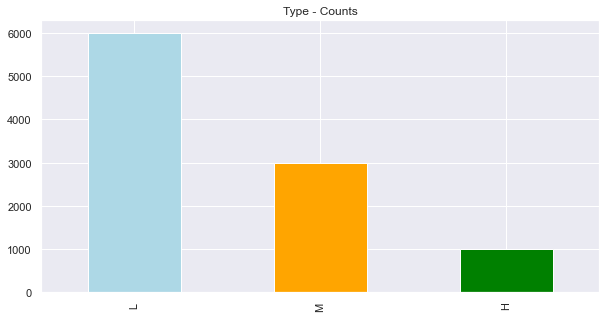

In [28]:
#######################################
#### Type Counts
df.type.value_counts().plot(kind='bar', title='Type - Counts',color=['lightblue','orange','green']);

- Failure counts vs overall counts split by 'Machine Type'

In [29]:
df.groupby('type')['machine_failure'].agg('value_counts').to_frame().rename(columns={'machine_failure':'count'})

count
type machine_failure       
H    0                  982
     1                   21
L    0                 5765
     1                  235
M    0                 2914
     1                   83

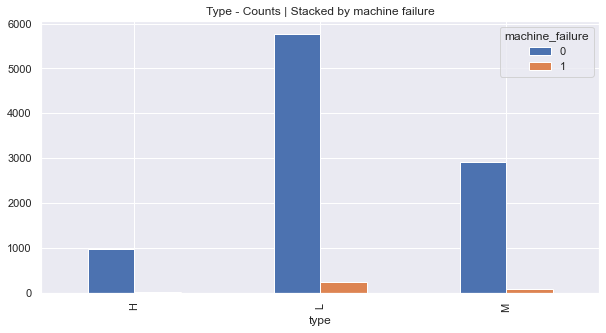

In [30]:
#######################################
#### Type Counts
#### Stacked by Failure
df.groupby('type')['machine_failure'].value_counts().unstack().plot(kind='bar', stacked = False, title='Type - Counts | Stacked by machine failure');

- Proportion of the 'Machine Type' that failed

In [31]:
counts_df = df.groupby('type')['machine_failure'].value_counts().unstack()
survived_percents_df = counts_df.T.div(counts_df.T.sum()).T

In [32]:
survived_percents_df

machine_failure,0,1
type,,
H,0.979063,0.020937
L,0.960833,0.039167
M,0.972306,0.027694


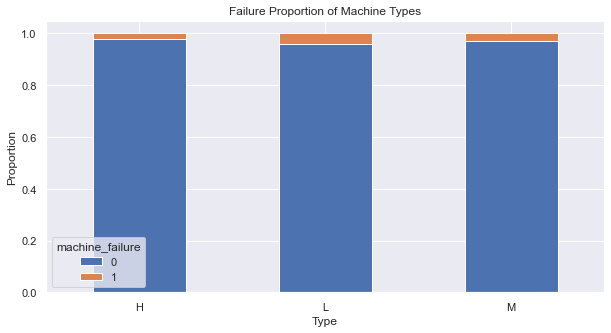

In [33]:
#######################################
#### Type Proportions
#### Stacked by Failure

fig, ax = plt.subplots()

survived_percents_df.plot(kind="bar", stacked=True, ax=ax,title='Failure Proportion of Machine Types')

ax.set_xlabel("Type")
ax.set_xticklabels(["H", "L", "M"], rotation=0)
ax.set_ylabel("Proportion");

Type 'L' has the highest number as well as percentage of machine failures

**About 4% of the 'Low' Types failed. As opposed to 2.1% failures for 'High'**. 
> 'L' types are nearly twice as likely to fail as the 'H' type

In [34]:
######################################

In [35]:
df.select_dtypes(include='object').columns

Index(['type'], dtype='object')

In [36]:
df

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0
9996,H,298.9,308.4,1632,31.8,17,0
9997,M,299.0,308.6,1645,33.4,22,0
9998,H,299.0,308.7,1408,48.5,25,0


### Numerical Features Analysis

In [37]:
features =df.drop('machine_failure', axis=1)
numerical_features = features.select_dtypes(include=np.number).columns
categorical_features = features.select_dtypes(exclude=np.number).columns

In [38]:
def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nDistribution of numeric features")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(10, 8))
    for index, col in enumerate(columns):
        if index > 0:
            plt.subplot(3, 2, index)
        sns.boxplot(y=df['machine_failure'].astype('category'), x=col, data=df)
    figure.tight_layout()
    plt.show()
    
    if len(df.select_dtypes(include='object').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='object').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=3, aspect=3)
                fig.set_xticklabels(rotation=90)
                plt.show()
    
    # Plot the pairwise joint distributions
    print("\nPairwise Joint Distribution of Numeric Data")
    if hue==None:
        sns.pairplot(df.select_dtypes(include=np.number))
    else:
        sns.pairplot(df.select_dtypes(include=np.number), hue=hue)
    plt.show()

- The idea is to perform individual univariate feature analysis
- Check Univariate analysis across categorical features
- Plot the Pairwise join distribution to understand the bivariate feature dependance
- Further check the correlation between the numerical features to understand the collinearity


Distribution of numeric features


,count,mean,std,min,25%,50%,75%,max
air_temperature_k,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
process_temperature_k,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
rotational_speed_rpm,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
torque_nm,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
tool_wear_min,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
machine_failure,10000.0,0.03390,0.180981,0.0,0.0,0.0,0.0,1.0


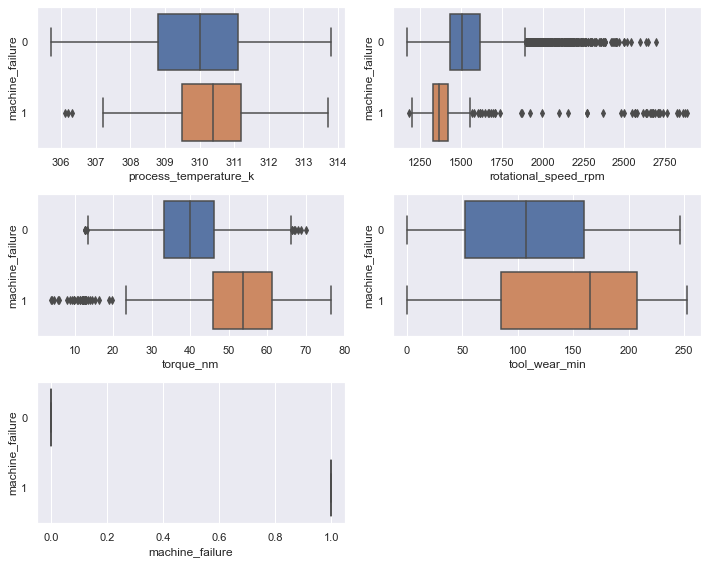

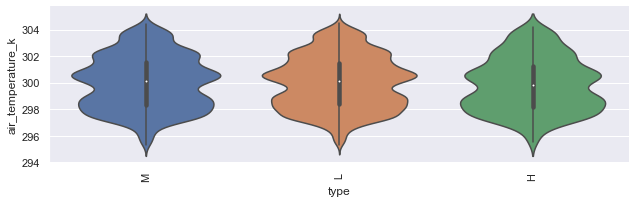

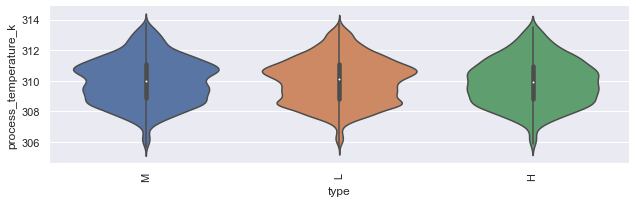

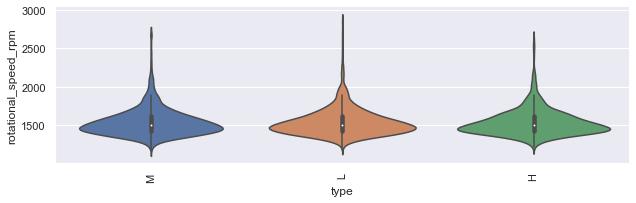

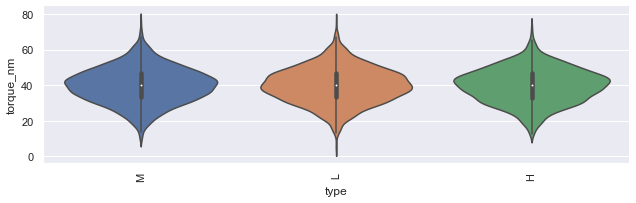

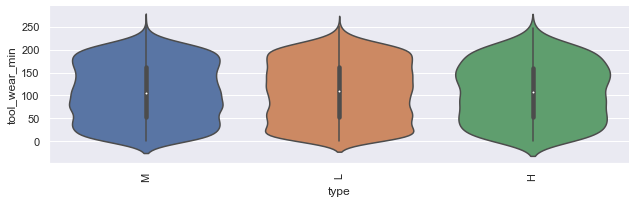

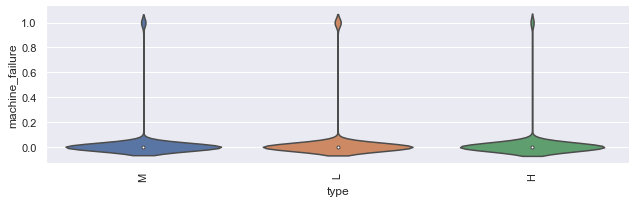


Pairwise Joint Distribution of Numeric Data


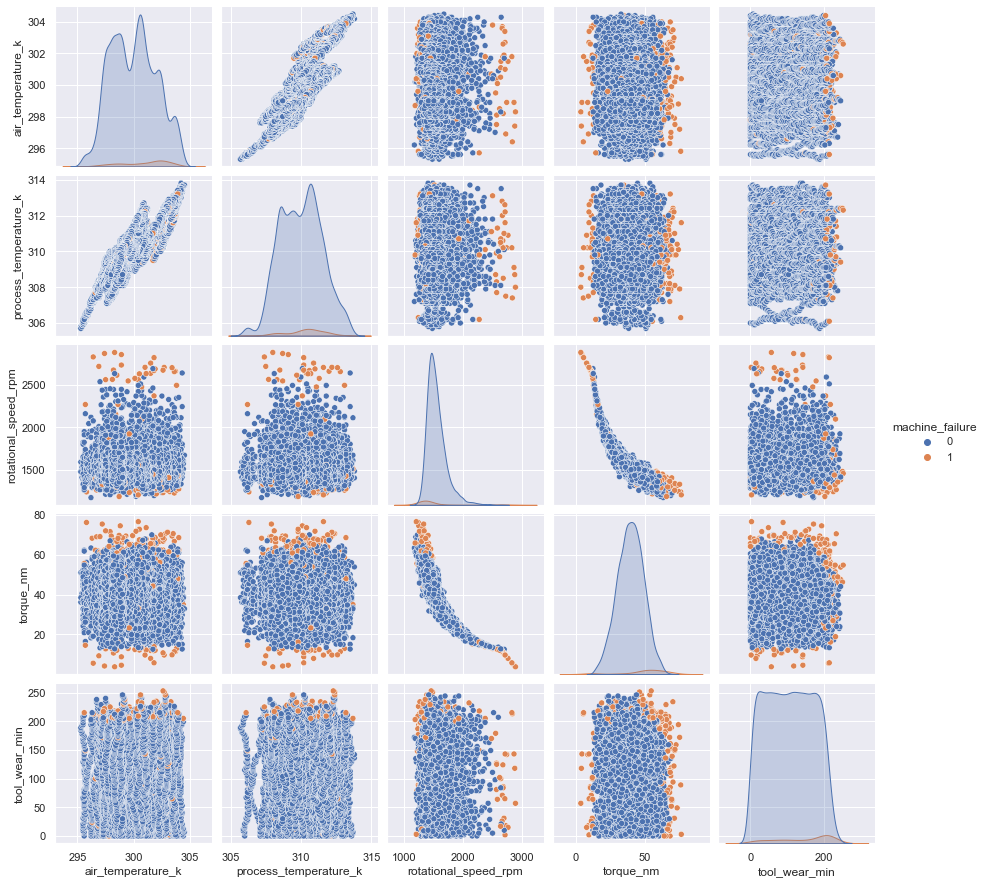

In [39]:
numeric_eda(df, hue='machine_failure')

In [40]:
# from the above violinplots,   numerical and 'type' features appear independent
# verifying that with numbers

df.groupby('type')[numerical_features].agg(['mean','std','median'])

air_temperature_k                  process_temperature_k            \
                  mean       std median                  mean       std   
type                                                                      
H           299.866999  2.021831  299.8            309.925723  1.489362   
L           300.015833  1.987453  300.1            310.012300  1.475247   
M           300.029263  2.017358  300.1            310.018785  1.498407   

            rotational_speed_rpm                      torque_nm             \
     median                 mean         std  median       mean        std   
type                                                                         
H     309.9          1538.147557  173.133428  1500.0  39.838285   9.642339   
L     310.1          1539.469167  180.428518  1504.0  39.996600  10.012335   
M     310.0          1537.598932  179.059828  1503.0  40.017251   9.992153   

            tool_wear_min                    
     median          mean        std median  
type                                         
H      40.3    107.419741  63.080140  107.0  
L      40.0    108.378833  64.058238  109.0  
M      40.2    107.272272  63.044646  106.0

> The numerical features are independent of the 'type' feature.

In [41]:
### Create Correlation Matrix for the Numerical Features

In [42]:
corrmat = df.corr()

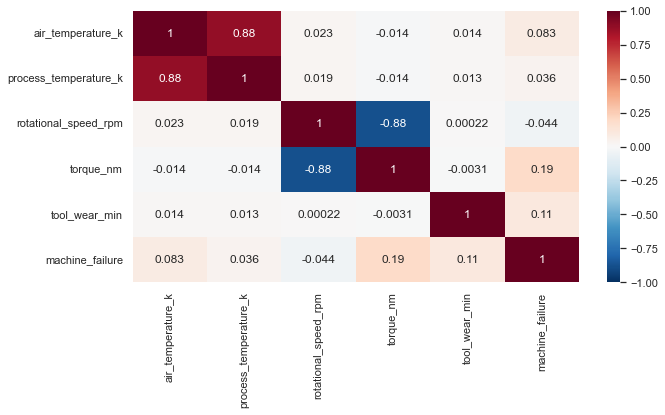

In [43]:
sns.heatmap(corrmat,cmap='RdBu_r', annot=True,vmin=-1, vmax=1);

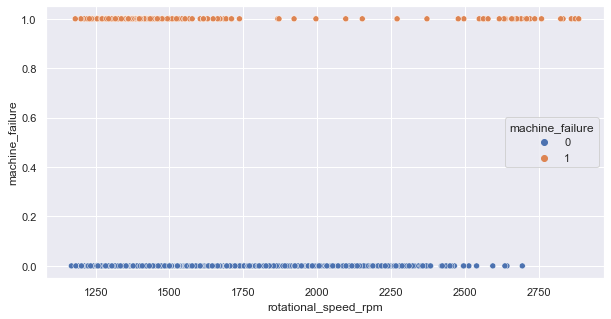

In [44]:
sns.scatterplot(df.rotational_speed_rpm, df.machine_failure, hue=df.machine_failure);

#### Numerical Features EDA Summary:
- None of the numerical features take negative values
- There is strong positive correlation between the the air_temperature and the process temperature (correlation of 0.88)
- Likewise, there is a strong negative correlation between the torque and the rotational speed (corr = 0.88)
- The temperatures and the torque have an approximately gaussian distribution
- The rotational_speed has a very distibution skewed to the right, with a long right tail
- The tool_wear exhibits uniform distribution, with a mean value of 107.85 minutes
- Understanding the relation between the features is essential to evaluate the model and the parameters it assigns to individual features. Correlation between the numerical features is studied above. We can also use other instruments like mutual_information (information_gain) to better understand the features relations.

    

## Feature Engineering

The data description provides insights into the combination of features that determine the machine failure criteria.<br>
In absense of this information, domain knowledge or getting insights from domain experts is the best way to perform feature engineering.<br><br>
New Feature 1: **Process Temperature - Air Temperature** <br><br>
New Feature 2: **Torque x Rotational Speed** <br><br>
New Feature 3: **Total Wear x Torque**

In [45]:
df_fe = df.copy()

In [46]:
df_fe.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [47]:
df_fe['at_pt'] = df_fe.process_temperature_k - df_fe.air_temperature_k
df_fe['tor_rot'] = df_fe.torque_nm*df_fe.rotational_speed_rpm
df_fe['tw_tor'] = df_fe.torque_nm*df_fe.tool_wear_min

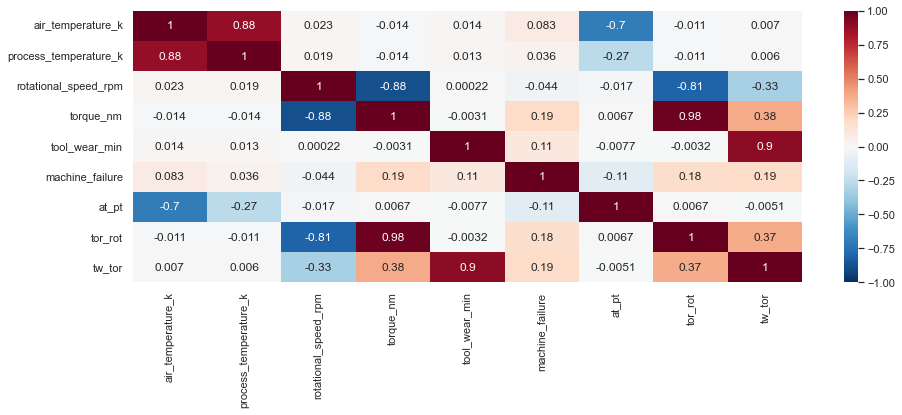

In [48]:
corrmat_fe = df_fe.corr()

f, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(corrmat_fe,cmap='RdBu_r', annot=True,vmin=-1, vmax=1);

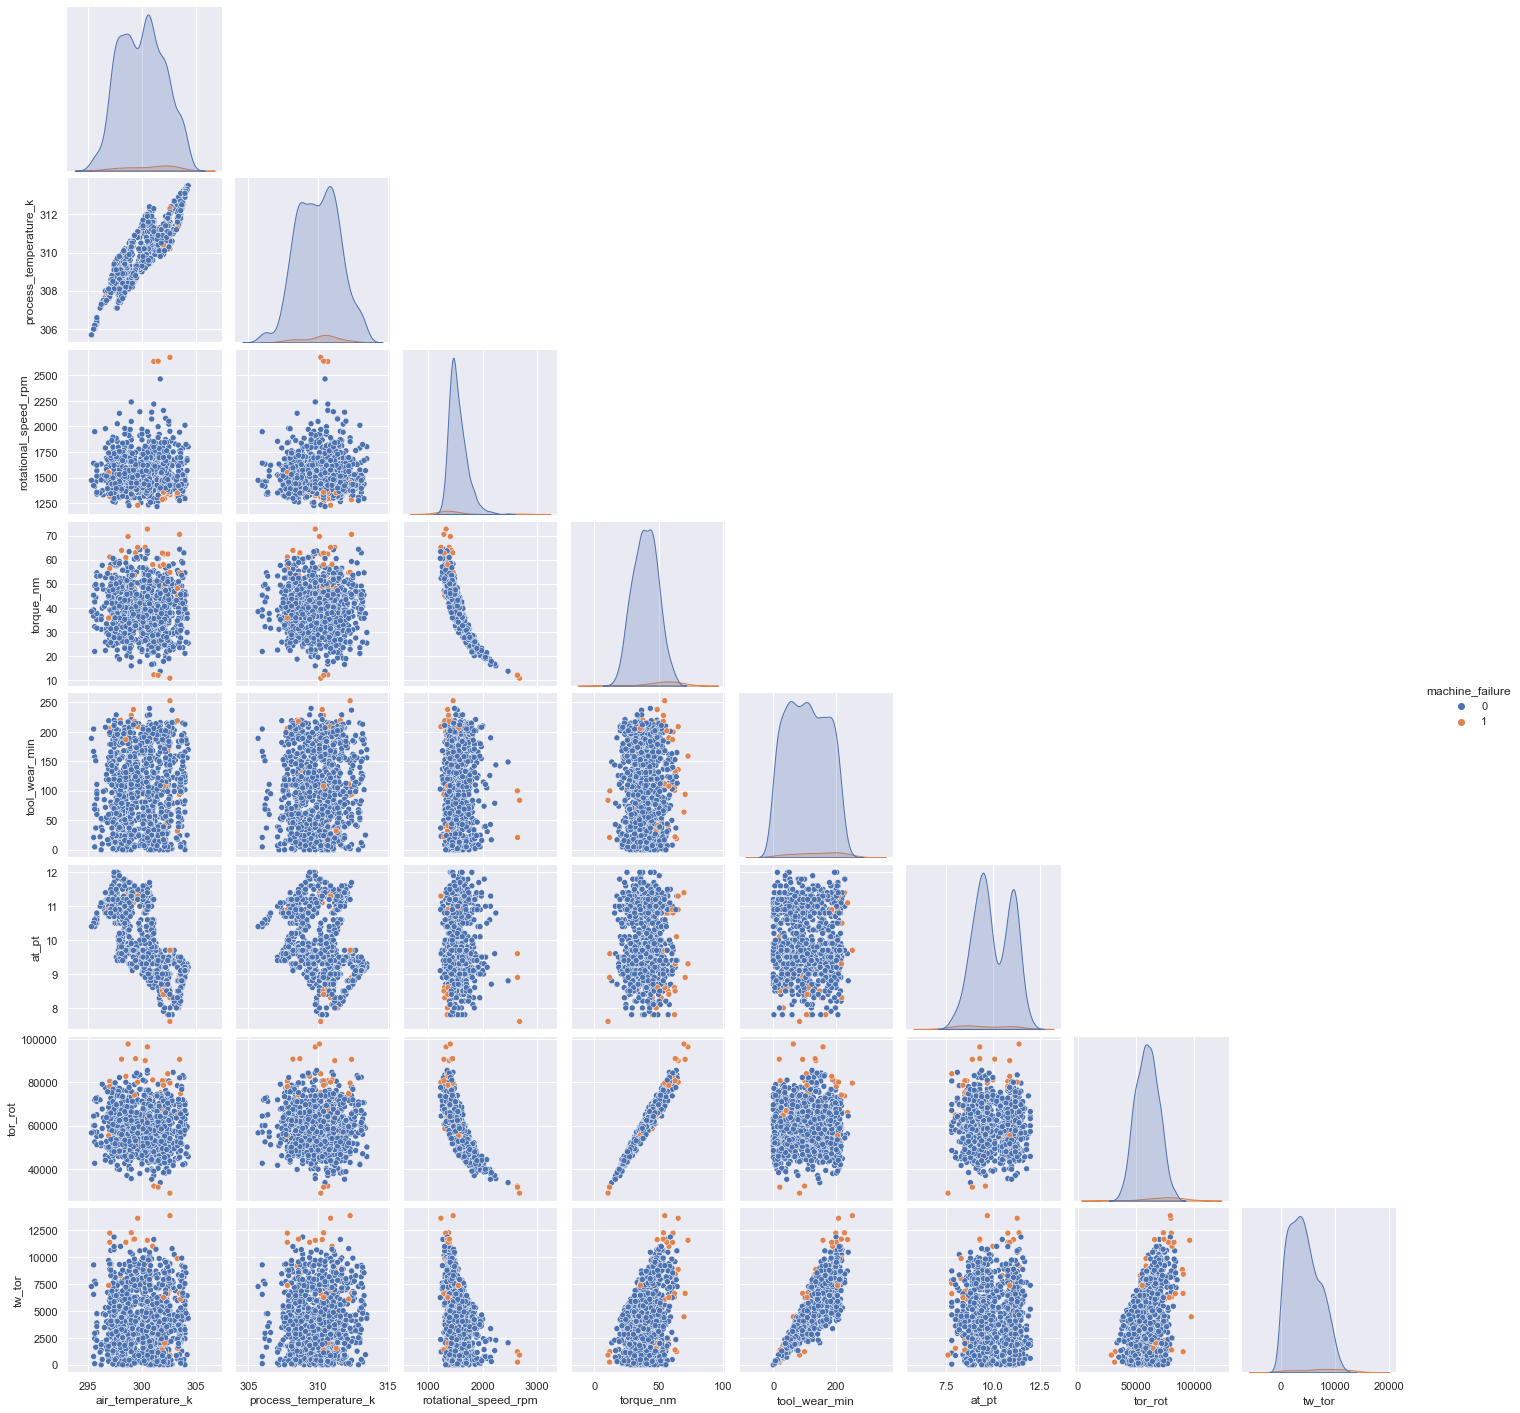

In [49]:
sns.pairplot(df_fe.select_dtypes(include=np.number).sample(1000), hue='machine_failure', corner=True);

In [50]:
df_fe.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,at_pt,tor_rot,tw_tor
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,10.000630,59967.147040,4314.664550
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,1.001094,10193.093881,2826.567692
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,7.600000,10966.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,9.300000,53105.400000,1963.650000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,9.800000,59883.900000,4012.950000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,11.000000,66873.750000,6279.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,12.100000,99980.400000,16497.000000


## Feature Selection 

- We have 9 features (6 original + 3 engineered)
- There is wide multi collinearity between the features
    - the temperature features (air_temperature, process_temperature, at_pt) are correlated
    - The rotational speed, torque  and tor_rot features are correlated
- It is possible that a few features could be dropped. This can be evaluated using  'feature selection test'. Since all these features are 'numerical', we can use tests like
    - ANOVA (f- statistic test)
    - Mutual Information 

In [51]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

#### ANOVA test

**The ANOVA test compares degree of explained variances between features wrt the target variable.** 

In [52]:
X = df_fe[numerical_features]
y = df_fe.machine_failure

In [53]:
## ANOVA F test
def feature_selection(X, y, score_func):
    feats = SelectKBest(score_func=score_func, k='all');  # selecting all the features, but will extract the feature importances
    feats.fit(X,y);                                      # fit the data
    for i, feat in enumerate(feats.scores_):
        print(numerical_features[i], f'score: {feat}')
    plt.bar(numerical_features, feats.scores_)
    plt.xticks(range(len(numerical_features)), numerical_features, rotation=90)
    # plt.title(f'Features Scores: {str(score_func)}')
    plt.show();
    return feats
    

air_temperature_k score: 68.6083847394097
process_temperature_k score: 12.93525964472095
rotational_speed_rpm score: 19.559690358274537
torque_nm score: 379.86772341991554
tool_wear_min score: 112.42107677956426


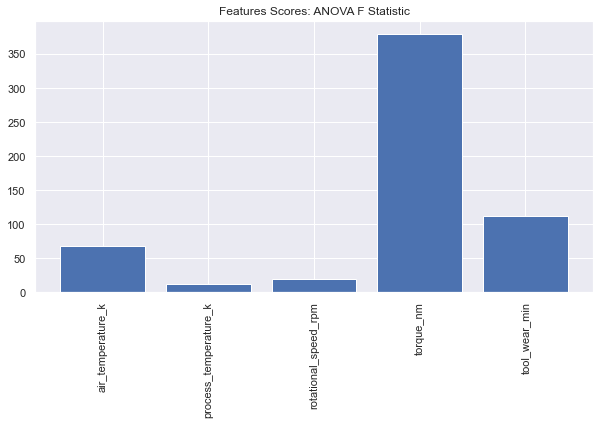

In [54]:
plt.title('Features Scores: ANOVA F Statistic')
feature_selection(X, y, f_classif);

> It appears that the **process temperature, rotational speed** are the least useful features to predict machine failure (per the ANOVA test)

#### Mutual Information (Information gain / entropy) test

**The mutual information test compares the features by the degree of reduction in entropy (Information gain) wrt the target variable**

air_temperature_k score: 0.007229836236708476
process_temperature_k score: 0.004834002288451877
rotational_speed_rpm score: 0.036655193112814066
torque_nm score: 0.048503451058422575
tool_wear_min score: 0.011732232525282438


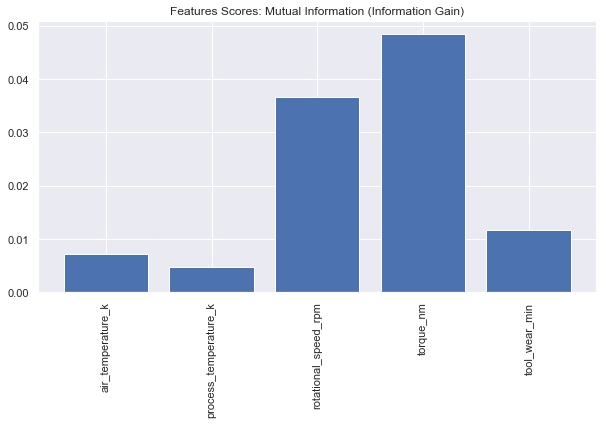

In [55]:
## Mutual Information test
plt.title('Features Scores: Mutual Information (Information Gain)')
feature_selection(X, y, mutual_info_classif);

> It appears that the **process temperature** is the least useful features to predict machine failure (per this Information gain test)

## Modeling

- The idea here is to start with a baseline simple, interpretable model
    - linear models (logistic)
    - SVC
    - Decision Tree Classifier
- Then explore other complex ensemble models 
    - Random Forest Classifier
    - Boosted Tree Classifers
        - xgboost
        - lightgbm
- We can further explore stacking models
- Neural Networks

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, confusion_matrix, roc_curve, auc,classification_report,roc_auc_score, f1_score

### Preprocessing

In [57]:
features =df_fe.drop('machine_failure', axis=1)
numerical_features = features.select_dtypes(include=np.number).columns
categorical_features = features.select_dtypes(exclude=np.number).columns

In [58]:
# Scale Numeric Data, One-Hot Encode Categorical data

In [59]:
def scalar_preprocess(nums, cats):
    scaled = ColumnTransformer(transformers=[('num', StandardScaler(), nums),
                                             ('cat', OneHotEncoder(), cats)],
                                              remainder='passthrough')
    return scaled

In [60]:
# test train split

In [61]:
def get_test_train(X, y, ratio):
    return train_test_split(X, y, test_size=ratio, random_state=42, stratify=y)

In [62]:
# Define Functions

In [63]:
   

def model_fit_predict(X_train, y_train, X_test, y_test, est):
    est = est.fit(X_train,y_train)
    y_pred = est.predict(X_test)
    y_pred_prob  = est.predict_proba(X_test)[:,1]
    return est, y_test, y_pred, y_pred_prob 


def model_results(y_test, y_pred, y_pred_prob):
    print("****************** MODEL RESULTS *******************\n")
    auc = roc_auc_score(y_test, y_pred_prob)
    f1s = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accu = accuracy_score(y_test, y_pred)
    
    res_df = pd.DataFrame({"Metrics": ['ROC AUC Score', 'Accuracy', 'Recall', 'Precision',  'F1 Score'],'Scores':[auc, accu, recall, precision, f1s]})
    
    display(res_df.round(3))

    

def feat_imp(features, importance):
    print("\n******************** Feature Importance **********************\n")
    for i,v in enumerate(importance):
        print(f'Feature: {features[i]}, Score:{v:.3f} ')
    # plot feature importance
    plt.bar(features, importance)
    plt.xticks(range(len(features)), features, rotation=90)
    plt.show()


def confmat(y_test, y_pred):
    print("\n******************** Confusion Matrix **********************\n")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6,3))
    sns.heatmap(conf_matrix, annot = True, fmt='g')
    plt.show()

    
def rocauc(y_test, y_pred_prob, est):
    print("\n********************ROC Curve**********************")
    fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr,tpr,label=f"{str(est.__class__.__name__)}, auc={auc:.3f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    # plot_roc_curve(y_test, y_pred_prob)
    plt.show()    

    
def prec_rec(y_test, y_pred_prob, est):
    print("\n********************Precision - Recall Curve**********************")
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall, precision, marker='.', label= str(est.__class__.__name__))
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend(loc=3)
    plt.show();
    
    
def model_report(est, y_test, y_pred, y_pred_prob):
    print("\n******************** FULL REPORT **********************") 
    print("\n******************** Classificaion Report **********************")
    print(classification_report(y_test, y_pred))
    
    confmat(y_test, y_pred)
    rocauc(y_test, y_pred_prob, est)
    prec_rec(y_test, y_pred_prob, est)   
             

    
def model_evaluate(X_train, y_train, X_test, y_test, est, features, summary = False, report=False, features_importance = False):
    """
    Fits the model
    Displays the summary of results with 'summary = True'
    Dsiplays the complete report with 'report = True'
    Returns the 'y_pred, y_pred_prob'
    """
    est, _, y_pred, y_pred_prob = model_fit_predict(X_train, y_train, X_test, y_test, est)
    if summary:
        model_results(y_test, y_pred, y_pred_prob)
    if report:
        model_report(est, y_test, y_pred, y_pred_prob)
    if features_importance:
        if est.__class__.__name__ == 'LogisticRegression':
            importance = est.coef_[0]
        
        else:
            importance = est.feature_importances_
            
        feat_imp(features, importance)
        
    return y_test, y_pred, y_pred_prob    
    

#### Test Train Split

In [64]:
X = df_fe.drop('machine_failure', axis=1)
y = df_fe['machine_failure']

In [65]:
scaled = scalar_preprocess(numerical_features, categorical_features)

In [66]:
X = scaled.fit_transform(X)

In [67]:
# Perform the split keeping the failure ratio the same

In [68]:
X_train, X_test, y_train, y_test = get_test_train(X,y,0.3)

In [69]:
print(f"train_ratio = {y_train.sum()/y_train.count()}, test_ratio = { y_test.sum()/y_test.count()}")

train_ratio = 0.033857142857142856, test_ratio = 0.034


#### Model Evaluation

- Heavy class Imbalance Problem. 
- Using the right metrics is essential. Accuracy is a weak metric to evaluate the model. 
- ROC AUC, Recall, Precision, F1-Score based metrics are ideal for these use cases.
- The Use case determines the right metric for the model. Depends on if we are trying to reduce the 'False Positives' or 'False Negatives'

> The model_evaluate function takes as input:
> - The data : *X_train, y_train, X_test, y_test*
> - The *estimator*
> - Results *summary* Boolean - True if you want to see a short summary of metrics
> - *report* - True if you want to see complete performance report
> - *features_importance* - True if you want to see a summary of features importance determined by the model

#### Baseline Model - Logistic Regression

In [70]:
features = list(numerical_features)+['type_H','type_L','type_M']

In [71]:
lr = LogisticRegression(solver='lbfgs')

****************** MODEL RESULTS *******************



,Metrics,Scores
0,ROC AUC Score,0.910
1,Accuracy,0.968
2,Recall,0.196
3,Precision,0.588
4,F1 Score,0.294



******************** FULL REPORT **********************

******************** Classificaion Report **********************
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2898
           1       0.59      0.20      0.29       102

    accuracy                           0.97      3000
   macro avg       0.78      0.60      0.64      3000
weighted avg       0.96      0.97      0.96      3000


******************** Confusion Matrix **********************



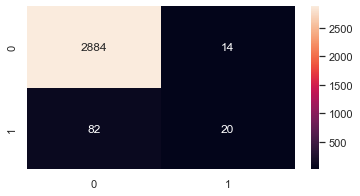


********************ROC Curve**********************


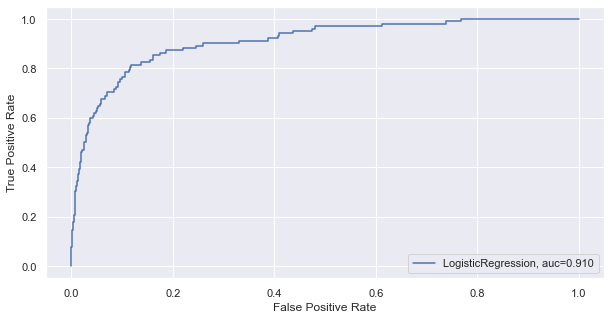


********************Precision - Recall Curve**********************


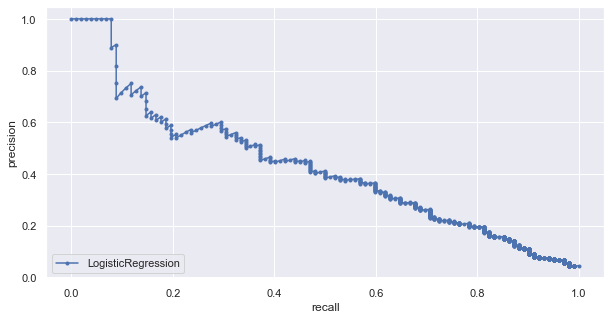


******************** Feature Importance **********************

Feature: air_temperature_k, Score:0.261 
Feature: process_temperature_k, Score:-0.095 
Feature: rotational_speed_rpm, Score:2.218 
Feature: torque_nm, Score:5.203 
Feature: tool_wear_min, Score:0.804 
Feature: at_pt, Score:-0.662 
Feature: tor_rot, Score:-2.347 
Feature: tw_tor, Score:0.036 
Feature: type_H, Score:-0.272 
Feature: type_L, Score:0.443 
Feature: type_M, Score:-0.173 


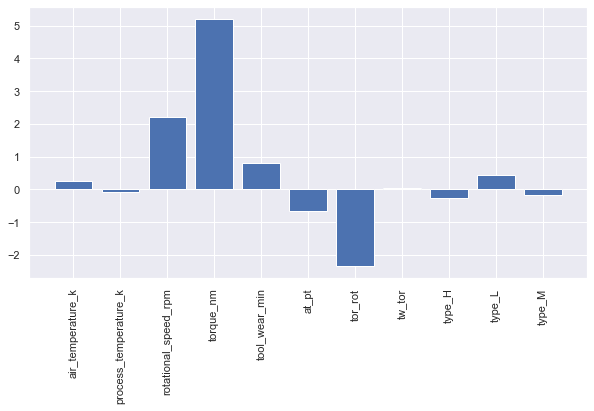

In [72]:
model_evaluate(X_train, y_train, X_test, y_test, lr, features, summary=True, report=True, features_importance=True);

- The logistic (linear) model is not able to capture sufficient signal from the engineering features. The engineered features are directly related to the target variable

#### Ensemble - Random Forest Classifier

In [73]:
rf = RandomForestClassifier()

****************** MODEL RESULTS *******************



,Metrics,Scores
0,ROC AUC Score,0.981
1,Accuracy,0.994
2,Recall,0.843
3,Precision,0.966
4,F1 Score,0.901



******************** Feature Importance **********************

Feature: air_temperature_k, Score:0.032 
Feature: process_temperature_k, Score:0.035 
Feature: rotational_speed_rpm, Score:0.159 
Feature: torque_nm, Score:0.148 
Feature: tool_wear_min, Score:0.061 
Feature: at_pt, Score:0.118 
Feature: tor_rot, Score:0.207 
Feature: tw_tor, Score:0.202 
Feature: type_H, Score:0.005 
Feature: type_L, Score:0.019 
Feature: type_M, Score:0.014 


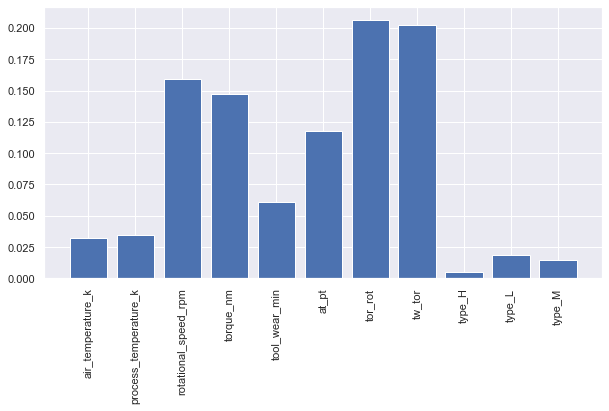

In [74]:
model_evaluate(X_train, y_train, X_test, y_test, rf, features, summary=True, report=False, features_importance=True);

#### Boosted Trees - xgboost

In [75]:
import xgboost as xgb

In [76]:
xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

****************** MODEL RESULTS *******************



,Metrics,Scores
0,ROC AUC Score,0.992
1,Accuracy,0.993
2,Recall,0.833
3,Precision,0.955
4,F1 Score,0.890



******************** Feature Importance **********************

Feature: air_temperature_k, Score:0.030 
Feature: process_temperature_k, Score:0.032 
Feature: rotational_speed_rpm, Score:0.159 
Feature: torque_nm, Score:0.044 
Feature: tool_wear_min, Score:0.096 
Feature: at_pt, Score:0.077 
Feature: tor_rot, Score:0.193 
Feature: tw_tor, Score:0.178 
Feature: type_H, Score:0.027 
Feature: type_L, Score:0.138 
Feature: type_M, Score:0.027 


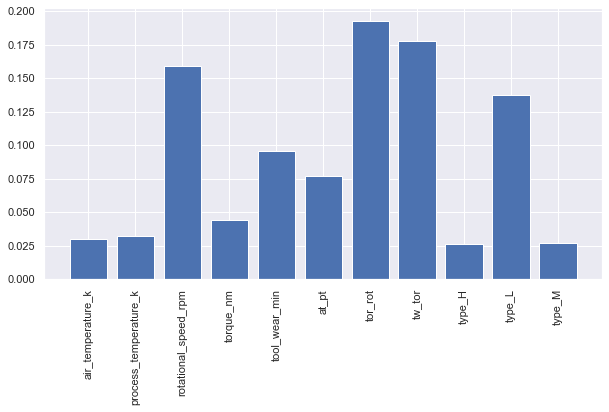

In [77]:
model_evaluate(X_train, y_train, X_test, y_test, xgbc, features, summary=True, report=False, features_importance=True);

#### Boosted Trees - lightgbm

In [78]:
lgbc = lgb.LGBMClassifier()

****************** MODEL RESULTS *******************



,Metrics,Scores
0,ROC AUC Score,0.986
1,Accuracy,0.991
2,Recall,0.824
3,Precision,0.894
4,F1 Score,0.857



******************** Feature Importance **********************

Feature: air_temperature_k, Score:250.000 
Feature: process_temperature_k, Score:269.000 
Feature: rotational_speed_rpm, Score:400.000 
Feature: torque_nm, Score:391.000 
Feature: tool_wear_min, Score:410.000 
Feature: at_pt, Score:313.000 
Feature: tor_rot, Score:486.000 
Feature: tw_tor, Score:375.000 
Feature: type_H, Score:20.000 
Feature: type_L, Score:46.000 
Feature: type_M, Score:40.000 


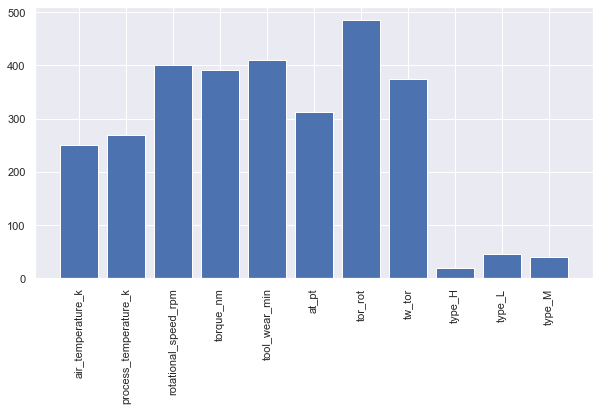

In [79]:
model_evaluate(X_train, y_train, X_test, y_test, lgbc, features, summary=True, report=False, features_importance=True);

### Model with Selected Features

> The features selection section (1.6) showed that the process temperature might be the least relevant feature. <br>
> Model evaluated with 'process temperature' removed

In [80]:
featuresk=['air_temperature_k',
 'rotational_speed_rpm',
 'torque_nm',
 'tool_wear_min',
 'at_pt',
 'tor_rot',
 'tw_tor',
 'type_H',
 'type_L',
 'type_M']

In [81]:
# removed process_temperature feature. 
# from kbest feature selection

numerical_featuresk = ['air_temperature_k', 'rotational_speed_rpm',
       'torque_nm', 'tool_wear_min', 'at_pt', 'tor_rot', 'tw_tor']

In [82]:
## Evaluate the models 

In [83]:
Xk = df_fe.drop(['process_temperature_k','machine_failure'], axis=1)
yk = df_fe['machine_failure']

In [84]:
scaledk = scalar_preprocess(['air_temperature_k', 'rotational_speed_rpm',
       'torque_nm', 'tool_wear_min', 'at_pt', 'tor_rot', 'tw_tor'], categorical_features)

In [85]:
Xk = scaledk.fit_transform(Xk)

In [86]:
X_traink, X_testk, y_traink, y_testk = get_test_train(Xk,yk,0.3)

In [87]:
xgbck = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

****************** MODEL RESULTS *******************



,Metrics,Scores
0,ROC AUC Score,0.986
1,Accuracy,0.993
2,Recall,0.824
3,Precision,0.966
4,F1 Score,0.889



******************** FULL REPORT **********************

******************** Classificaion Report **********************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2898
           1       0.97      0.82      0.89       102

    accuracy                           0.99      3000
   macro avg       0.98      0.91      0.94      3000
weighted avg       0.99      0.99      0.99      3000


******************** Confusion Matrix **********************



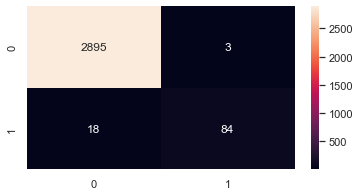


********************ROC Curve**********************


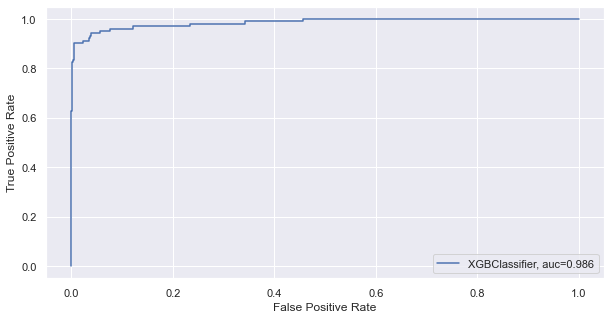


********************Precision - Recall Curve**********************


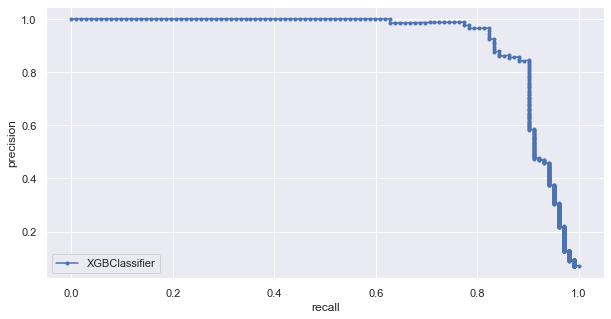


******************** Feature Importance **********************

Feature: air_temperature_k, Score:0.033 
Feature: rotational_speed_rpm, Score:0.167 
Feature: torque_nm, Score:0.044 
Feature: tool_wear_min, Score:0.098 
Feature: at_pt, Score:0.077 
Feature: tor_rot, Score:0.201 
Feature: tw_tor, Score:0.171 
Feature: type_H, Score:0.018 
Feature: type_L, Score:0.158 
Feature: type_M, Score:0.032 


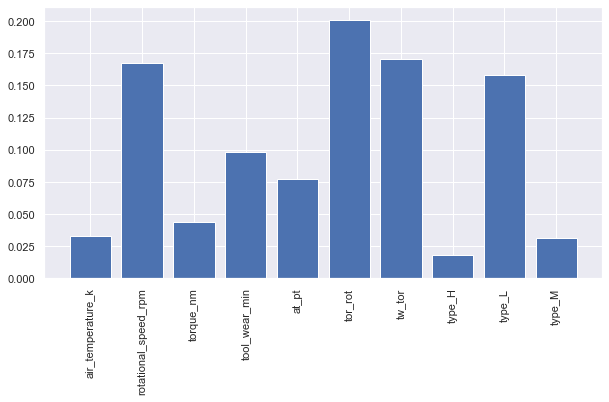

In [88]:
model_evaluate(X_traink, y_traink, X_testk, y_testk, xgbck, featuresk, summary=True, report=True, features_importance=True);

> **Dropping the 'Process Temperauture' feature did not affect the model performance significantly.**

## Compare Models

#### Comparing Different Classification Models:
- Linear Model (Logistic Regression)
- Decision Tree
- Random Forest
- XGBoost
- Light GBM

> *Note that we can always add many other classifiers to compare and showcase, but typically for a classification problem with tabular data and heavy class imbalance, ***tree based models*** are always highly performant* <br>

> Few estimators that can be added to compare are K-Nearest Neighbors, SVC, MLP Network, Advanced Neural Networks etc.

In [89]:
# defining list of models
estimators = {'Logistic Regression': LogisticRegression(solver='lbfgs'),
              'Decision Tree': RandomForestClassifier(), 
              'Random Forest': DecisionTreeClassifier(), 
              'XGBoost': xgb.XGBClassifier(eval_metric='auc'), 
              'Light GBM': lgb.LGBMClassifier()}

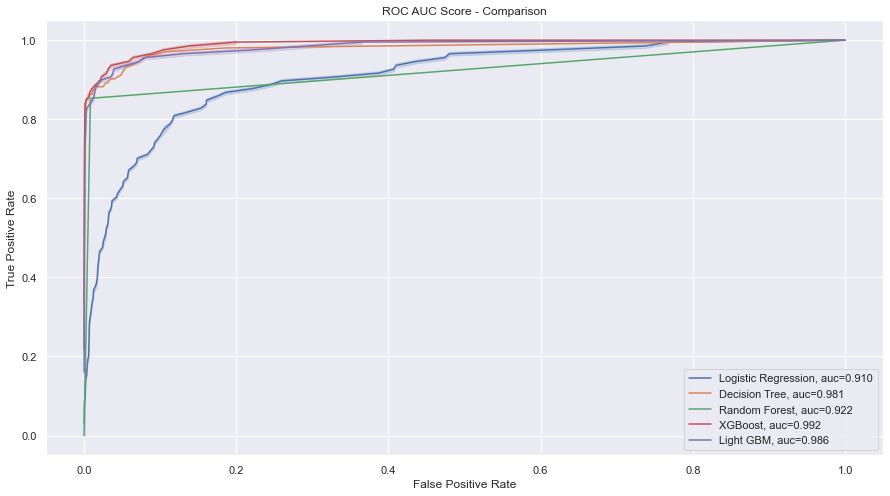

In [90]:
y_preds = {}
y_pred_probas = {}
aucs = {}
plt.figure(figsize=(15,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for est_name, est in estimators.items():
    y_test, y_preds[est_name], y_pred_probas[est_name] = model_evaluate(X_train, y_train, X_test, y_test, est, features)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_probas[est_name])
    aucs[est_name] = roc_auc_score(y_test, y_pred_probas[est_name])
    sns.lineplot(fpr,tpr,label=f"{est_name}, auc={aucs[est_name]:.3f}")
plt.title('ROC AUC Score - Comparison')
plt.show()    

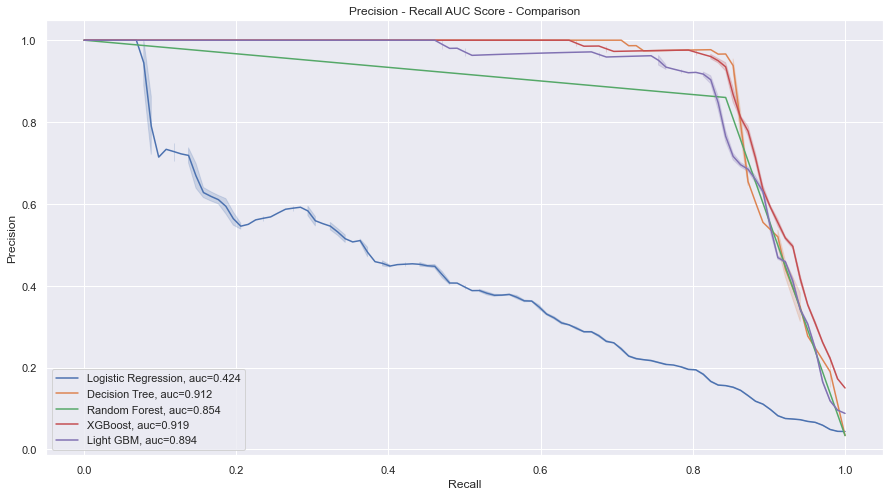

In [91]:
y_preds = {}
y_pred_probas = {}
prec_aucs = {}
plt.figure(figsize=(15,8))
plt.xlabel('Recall')
plt.ylabel('Precision')
for est_name, est in estimators.items():
    y_test, y_preds[est_name], y_pred_probas[est_name] = model_evaluate(X_train, y_train, X_test, y_test, est, features)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_probas[est_name])
    prec, rec, thresholds = precision_recall_curve(y_test, y_pred_probas[est_name])
    prec_aucs[est_name] = auc(rec, prec)
    sns.lineplot(rec,prec,label=f"{est_name}, auc={prec_aucs[est_name]:.3f}")
plt.title('Precision - Recall AUC Score - Comparison')
plt.show()    

In [92]:
recall_scores = {}
precision_scores = {}
f1_scores = {}
accuracy_scores ={}
for est_name, est in estimators.items():
    recall_scores[est_name] = recall_score(y_test,  y_preds[est_name] )
    precision_scores[est_name] = precision_score(y_test,  y_preds[est_name] )
    f1_scores[est_name] = f1_score(y_test,  y_preds[est_name] )
    accuracy_scores[est_name] = accuracy_score(y_test,  y_preds[est_name] )

In [93]:
df_compare = pd.DataFrame.from_dict([aucs, prec_aucs, recall_scores,precision_scores,f1_scores,accuracy_scores])

In [94]:
metrics = ['AUC', 'PR AUC','Recall','Precision','F1-score','Accuracy']
df_compare['metrics'] = metrics

In [95]:
df_compare.set_index('metrics').round(3).T

metrics,AUC,PR AUC,Recall,Precision,F1-score,Accuracy
Logistic Regression,0.910,0.424,0.196,0.588,0.294,0.968
Decision Tree,0.981,0.912,0.833,0.966,0.895,0.993
Random Forest,0.922,0.854,0.843,0.860,0.851,0.990
XGBoost,0.992,0.919,0.833,0.955,0.890,0.993
Light GBM,0.986,0.894,0.824,0.894,0.857,0.991


> - As can be seen the **XGBoost** is the most robust across all metrics. <br>
> - The right metrics should be chosen based on the business use case. That will determine the best performing model for that use case. <br>
> - Note that the modeling and comparison is performed on the vanilla models. This provides an idea on the model performances for this data. Further optimization with hyper parametric tuning via gridsearch will enable us to pick the optimum model for deployment.

## Next Steps

- Performed preliminary modeling with Logistic, RandomForestClassifier, XGBoostClassifier and LighGBMClassifier.
- This gives us an intuition on the data, model and the features. And to perform further steps and in tuning the selected models
- The tuning process should include cross validation, hyperparametric tuning with gridsearch methodology
- In addition to the above classifiers, we can try different kind of classifiers like the SVC, KNN, Neural Network etc. to find the best performing model for the given dataset
- ***Note that for the tabular data, tree based ensemble methods usually are the best performing models. The neural network rises to the top for unstructured data like video/audio/text etc.*** 
<br>
- The problem statement can be changed to Multi-Class Classification problem.
      - The machine fails in 5 failure modes. 
      - The failure modes are not independent, so multi label classification problem is more appropriate

END